# AIN311 COURSE PROJECT


## Feature  Desription :
url :https://data.scorenetwork.org/hockey/nhl-shots.html

| Variable                | Description                                                                                                     |
|-------------------------|-----------------------------------------------------------------------------------------------------------------|
| `game_id`               | Unique integer identifier for game shot took place in                                                          |
| `description`           | String detailed description of shot event                                                                      |
| `shot_outcome`          | String denoting the outcome of the shot, either BLOCKED_SHOT (meaning blocked by a non-goalie), GOAL, MISSED_SHOT (shot that missed the net), or SHOT (shot on net that was saved by a goalie) |
| `period`                | Integer value of the game period                                                                               |
| `period_seconds_remaining` | Numeric value of the seconds remaining in the period                                                       |
| `game_seconds_remaining`   | Numeric value of the seconds remaining in the game; negative for overtime periods                         |
| `home_score`            | Integer value of the home team score after the event                                                           |
| `away_score`            | Integer value of the away team score after the event                                                           |
| `home_name`             | String name of the home team                                                                                   |
| `away_name`             | String name of the away team                                                                                   |
| `event_team`            | String defining the team taking the shot                                                                      |
| `event_goalie_name`     | String name of goalie (if in net)                                                                             |
| `empty_net`             | Boolean indicating if the shot was during an empty net situation, TRUE if so but FALSE or NA if not           |
| `event_player_1_name`   | String name of the primary event player                                                                       |
| `event_player_1_type`   | String indicator for the role of event_player_1 (typically the shooter)                                       |
| `event_player_2_name`   | String name of the secondary event player                                                                     |
| `event_player_2_type`   | String indicator for the role of event_player_2 (blocker, assist, or goalie)                                  |
| `strength_code`         | String indicator for game strength: EV (Even), SH (Shorthanded), or PP (Power Play)                           |
| `x_fixed`               | Numeric transformed x-coordinate of event in feet, where the home team always shoots to the right, away team to the left |
| `y_fixed`               | Numeric transformed y-coordinate of event in feet, where the home team always shoots to the right, away team to the left |
| `shot_distance`         | Numeric distance (in feet) to center of net for unblocked shot events                                         |
| `shot_angle`            | Numeric angle (in degrees) to center of net for unblocked shot events                                          |


In [43]:
#import  libraries
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,KFold,learning_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt





### Data Summary


In [44]:
#load data and display
df = pd.read_csv('shots.csv')
df.head(5)

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
0,2021020001,Steven Stamkos Wrist Shot saved by Tristan Jarry,SHOT,1,1137,3537,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Steven.Stamkos,Shooter,Tristan.Jarry,Goalie,EV,61.0,-32.0,42.5,48.8
1,2021020001,Zach Bogosian shot blocked shot by Brock McGinn,BLOCKED_SHOT,1,1115,3515,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Zach.Bogosian,Shooter,Brock.McGinn,Blocker,EV,60.0,-17.0,NaN,NaN
2,2021020001,Brock McGinn Wrist Shot saved by Andrei Vasile...,SHOT,1,1096,3496,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Brock.McGinn,Shooter,Andrei.Vasilevskiy,Goalie,EV,-65.0,19.0,30.6,38.4
3,2021020001,Jan Rutta Wrist Shot saved by Tristan Jarry,SHOT,1,1079,3479,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Jan.Rutta,Shooter,Tristan.Jarry,Goalie,EV,-8.0,-27.0,100.7,15.6
4,2021020001,Danton Heinen Wrist Shot saved by Andrei Vasil...,SHOT,1,1033,3433,0,0,Tampa Bay Lightning,Pittsburgh Penguins,...,NaN,Danton.Heinen,Shooter,Andrei.Vasilevskiy,Goalie,EV,-60.0,-4.0,29.3,7.9


In [45]:
# summary about entries and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160573 entries, 0 to 160572
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   game_id                   160573 non-null  int64  
 1   description               160573 non-null  object 
 2   shot_outcome              160573 non-null  object 
 3   period                    160573 non-null  int64  
 4   period_seconds_remaining  160573 non-null  int64  
 5   game_seconds_remaining    160573 non-null  int64  
 6   home_score                160573 non-null  int64  
 7   away_score                160573 non-null  int64  
 8   home_name                 160573 non-null  object 
 9   away_name                 160573 non-null  object 
 10  event_team                160573 non-null  object 
 11  event_goalie_name         89064 non-null   object 
 12  empty_net                 8712 non-null    object 
 13  event_player_1_name       160573 non-null  o

In [46]:
counts = df['shot_outcome'].value_counts().reset_index()
counts.columns = ['shot_outcome', 'Count']

fig = px.bar(counts, x='shot_outcome', y='Count', title=f"Distribution of {'shot_outcome'}")
fig.show()

classes are imbalanced , to adress this issue random undersampling will applied. Before this ı will handle missing values.

In [47]:
# Check for empty rows
empty_rows = df.isna().all(axis=1)
df[empty_rows]


,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,...,empty_net,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle


no empty row detected

In [48]:
#remove duplicates
df.drop_duplicates(inplace=True) 

no duplicate detected

In [49]:
df.isnull().sum()

game_id                          0
description                      0
shot_outcome                     0
period                           0
period_seconds_remaining         0
game_seconds_remaining           0
home_score                       0
away_score                       0
home_name                        0
away_name                        0
event_team                       0
event_goalie_name            71509
empty_net                   151860
event_player_1_name              0
event_player_1_type              0
event_player_2_name            374
event_player_2_type            374
strength_code                  306
x_fixed                         13
y_fixed                         13
shot_distance                38224
shot_angle                   38224
dtype: int64

In [50]:
df=df.drop('empty_net',axis=1) #empty_net is too sparse , drop it .


Three empty columns detected. There is missing values on x_fixed , y_fixed and strength_code. They are propotionally less occurane, I will drop them.

C:\Users\NURŞAH SATILMIŞ\AppData\Local\Temp\ipykernel_25976\22555277.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



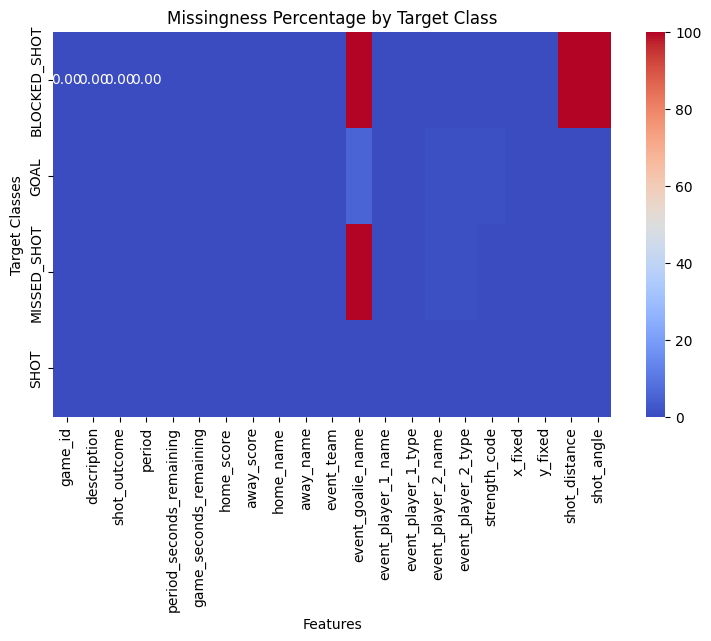

In [51]:
# Calculate missingness by target class
missing_by_target = df.groupby('shot_outcome').apply(lambda x: x.isnull().mean() * 100)


# Visualize missingness by target class
plt.figure(figsize=(9, 5))
sns.heatmap(missing_by_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Missingness Percentage by Target Class")
plt.xlabel("Features")
plt.ylabel("Target Classes")
plt.show()


In two classes, there are empty columns. Ensure to check each class separately.

In [52]:
df_class1= df[df['shot_outcome'] == 'SHOT'] #indicates saved shot 
df_class1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80647 entries, 0 to 160571
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   80647 non-null  int64  
 1   description               80647 non-null  object 
 2   shot_outcome              80647 non-null  object 
 3   period                    80647 non-null  int64  
 4   period_seconds_remaining  80647 non-null  int64  
 5   game_seconds_remaining    80647 non-null  int64  
 6   home_score                80647 non-null  int64  
 7   away_score                80647 non-null  int64  
 8   home_name                 80647 non-null  object 
 9   away_name                 80647 non-null  object 
 10  event_team                80647 non-null  object 
 11  event_goalie_name         80647 non-null  object 
 12  event_player_1_name       80647 non-null  object 
 13  event_player_1_type       80647 non-null  object 
 14  event_play

There are no missing values

In [53]:
df_class2=df[df['shot_outcome']=='BLOCKED_SHOT']
df_class2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38224 entries, 1 to 160572
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   38224 non-null  int64  
 1   description               38224 non-null  object 
 2   shot_outcome              38224 non-null  object 
 3   period                    38224 non-null  int64  
 4   period_seconds_remaining  38224 non-null  int64  
 5   game_seconds_remaining    38224 non-null  int64  
 6   home_score                38224 non-null  int64  
 7   away_score                38224 non-null  int64  
 8   home_name                 38224 non-null  object 
 9   away_name                 38224 non-null  object 
 10  event_team                38224 non-null  object 
 11  event_goalie_name         0 non-null      object 
 12  event_player_1_name       38224 non-null  object 
 13  event_player_1_type       38224 non-null  object 
 14  event_play

Shot_distance, shot_angle, and event_goalie_name are empty. Discarding this class from the task makes sense.

In [54]:
df_class3=df[df['shot_outcome']=='MISSED_SHOT']

df_class3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32765 entries, 19 to 160566
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   32765 non-null  int64  
 1   description               32765 non-null  object 
 2   shot_outcome              32765 non-null  object 
 3   period                    32765 non-null  int64  
 4   period_seconds_remaining  32765 non-null  int64  
 5   game_seconds_remaining    32765 non-null  int64  
 6   home_score                32765 non-null  int64  
 7   away_score                32765 non-null  int64  
 8   home_name                 32765 non-null  object 
 9   away_name                 32765 non-null  object 
 10  event_team                32765 non-null  object 
 11  event_goalie_name         0 non-null      object 
 12  event_player_1_name       32765 non-null  object 
 13  event_player_1_type       32765 non-null  object 
 14  event_pla

There is one empty column detected. There are missing values on strength code and event_player_2_name , event_player_2_type.

In [55]:
df_class4=df[df['shot_outcome']=='GOAL']
df_class4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8936 entries, 37 to 160523
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   8936 non-null   int64  
 1   description               8936 non-null   object 
 2   shot_outcome              8936 non-null   object 
 3   period                    8936 non-null   int64  
 4   period_seconds_remaining  8936 non-null   int64  
 5   game_seconds_remaining    8936 non-null   int64  
 6   home_score                8936 non-null   int64  
 7   away_score                8936 non-null   int64  
 8   home_name                 8936 non-null   object 
 9   away_name                 8936 non-null   object 
 10  event_team                8936 non-null   object 
 11  event_goalie_name         8416 non-null   object 
 12  event_player_1_name       8936 non-null   object 
 13  event_player_1_type       8936 non-null   object 
 14  event_play

In [56]:
class_1_undersampled = df_class1.sample(n=len(df_class4), random_state=42)
class_3_undersampled = df_class3.sample(n=len(df_class4), random_state=42)
sample_df = pd.concat([
    class_1_undersampled, 
    class_3_undersampled, 
    df_class4
])


In [57]:
sample_df = sample_df.drop("event_goalie_name",axis=1)
sample_df = sample_df.dropna()

## Corolation Analysis

Correlation analysis is a statistical method used to measure the strength and direction of the relationship between two variables. In the context of feature engineering, it helps identify how closely each feature is associated with the target variable. The correlation coefficient, which ranges from -1 to 1, quantifies this relationship. A value close to 1 indicates a strong positive correlation, meaning that as the feature value increases, the target variable also tends to increase. Conversely, a value close to -1 indicates a strong negative correlation, where an increase in the feature value is associated with a decrease in the target variable. A correlation coefficient near 0 suggests little to no linear relationship between the feature and the target.

In feature selection, correlation analysis is valuable for identifying relevant predictors. Features with high correlation to the target variable are likely to be useful for the model, while those with very low or no correlation may be irrelevant. Additionally, correlation analysis can reveal multicollinearity among features—situations where two or more features are highly correlated with each other. Multicollinearity can lead to redundancy and negatively impact the model's performance, so such features may need to be removed or transformed.

To start, I will calculate the correlation between the target variable and other features to identify significant relationships. Following this, I will create a correlation matrix to analyze the relationships between all features in the dataset. Finally, I will visualize the results using a heatmap, which will help highlight both the strength of the correlations and any potential multicollinearity among the features.

In [58]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26512 entries, 77888 to 160523
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   26512 non-null  int64  
 1   description               26512 non-null  object 
 2   shot_outcome              26512 non-null  object 
 3   period                    26512 non-null  int64  
 4   period_seconds_remaining  26512 non-null  int64  
 5   game_seconds_remaining    26512 non-null  int64  
 6   home_score                26512 non-null  int64  
 7   away_score                26512 non-null  int64  
 8   home_name                 26512 non-null  object 
 9   away_name                 26512 non-null  object 
 10  event_team                26512 non-null  object 
 11  event_player_1_name       26512 non-null  object 
 12  event_player_1_type       26512 non-null  object 
 13  event_player_2_name       26512 non-null  object 
 14  event_

There are categorical features , to use corrolation matrix I will encode them. 

In [59]:
categorical_features = sample_df.select_dtypes(include=['object','bool']).columns
numerical_features = sample_df.select_dtypes(exclude=['object','bool']).columns
display(sample_df[categorical_features].describe())
display(sample_df[numerical_features].describe())

,description,shot_outcome,home_name,away_name,event_team,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code
count,26512,26512,26512,26512,26512,26512,26512,26512,26512,26512
unique,24480,3,32,32,32,909,2,918,3,3
top,Vincent Trocheck Wide of Net Jeremy Swayman,SHOT,Edmonton Oilers,Tampa Bay Lightning,Colorado Avalanche,Auston.Matthews,Shooter,Andrei.Vasilevskiy,Goalie,EV
freq,6,8924,1039,1023,1073,141,17774,585,9499,20457


,game_id,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,x_fixed,y_fixed,shot_distance,shot_angle
count,2.651200e+04,26512.000000,26512.000000,26512.000000,26512.000000,26512.000000,26512.000000,26512.000000,26512.000000,26512.000000
mean,2.021021e+09,2.063028,578.471447,1732.382883,1.691083,1.532664,2.425543,0.303070,31.494757,29.189190
std,2.432544e+03,0.869252,350.515064,1057.190800,1.572221,1.460967,65.943606,17.003293,22.286113,21.133952
min,2.021020e+09,1.000000,0.000000,-1084.000000,0.000000,0.000000,-99.000000,-42.000000,1.000000,0.000000
25%,2.021020e+09,1.000000,270.000000,836.000000,0.000000,0.000000,-66.000000,-10.000000,14.300000,12.000000
50%,2.021021e+09,2.000000,577.000000,1739.000000,1.000000,1.000000,32.000000,0.000000,27.500000,26.600000
75%,2.021021e+09,3.000000,884.000000,2626.000000,3.000000,2.000000,69.000000,11.000000,44.000000,41.500000
max,2.021030e+09,6.000000,1196.000000,3594.000000,11.000000,10.000000,99.000000,42.000000,187.000000,164.100000


## Normalizing & Label Encoding

In [60]:
df_preprocessed = sample_df.copy()

scaler = MinMaxScaler()
df_preprocessed[numerical_features] = scaler.fit_transform(sample_df[numerical_features])

In [61]:
# target class encoding
label_encoding = {
    'GOAL': 0,
    'MISSED_SHOT': 1,
    'SHOT': 2,
}

df_preprocessed['shot_outcome'] = df_preprocessed['shot_outcome'].map(label_encoding)



In [62]:
categorical_features = df_preprocessed.select_dtypes(include=['object','bool']).columns
numerical_features = df_preprocessed.select_dtypes(exclude=['object','bool']).columns
encoder = LabelEncoder()
for i in categorical_features:
    df_preprocessed[i]=df_preprocessed[[i]].apply(encoder.fit_transform)
df_preprocessed.head()

,game_id,description,shot_outcome,period,period_seconds_remaining,game_seconds_remaining,home_score,away_score,home_name,away_name,event_team,event_player_1_name,event_player_1_type,event_player_2_name,event_player_2_type,strength_code,x_fixed,y_fixed,shot_distance,shot_angle
77888,0.066059,3547,2,0.2,0.244147,0.550663,0.454545,0.1,23,13,13,121,1,372,1,1,0.080808,0.511905,0.027419,0.057892
14485,0.012194,2517,2,0.0,0.383779,0.842882,0.000000,0.1,5,1,1,84,1,303,1,1,0.242424,0.333333,0.212366,0.123096
52194,0.044263,18730,2,0.0,0.112040,0.773407,0.000000,0.0,4,27,27,711,1,349,1,0,0.085859,0.500000,0.032258,0.000000
68083,0.057705,14917,2,0.0,0.653010,0.911714,0.000000,0.0,26,4,4,576,1,53,1,0,0.090909,0.571429,0.048387,0.224863
153039,0.974652,8176,2,0.4,0.123746,0.263360,0.090909,0.1,7,16,16,287,1,225,1,0,0.166667,0.702381,0.148387,0.222425


## Corroletion Analysis

shot_outcome                1.000000
event_player_1_type         0.865101
event_player_2_type         0.470897
shot_distance               0.228090
shot_angle                  0.069182
game_seconds_remaining      0.053677
period_seconds_remaining    0.038106
description                 0.015071
event_player_1_name         0.013976
game_id                     0.008679
home_name                   0.002984
y_fixed                     0.002043
away_name                   0.000049
event_team                 -0.004155
x_fixed                    -0.010700
period                     -0.054906
event_player_2_name        -0.083944
strength_code              -0.108037
home_score                 -0.166067
away_score                 -0.168639
Name: shot_outcome, dtype: float64


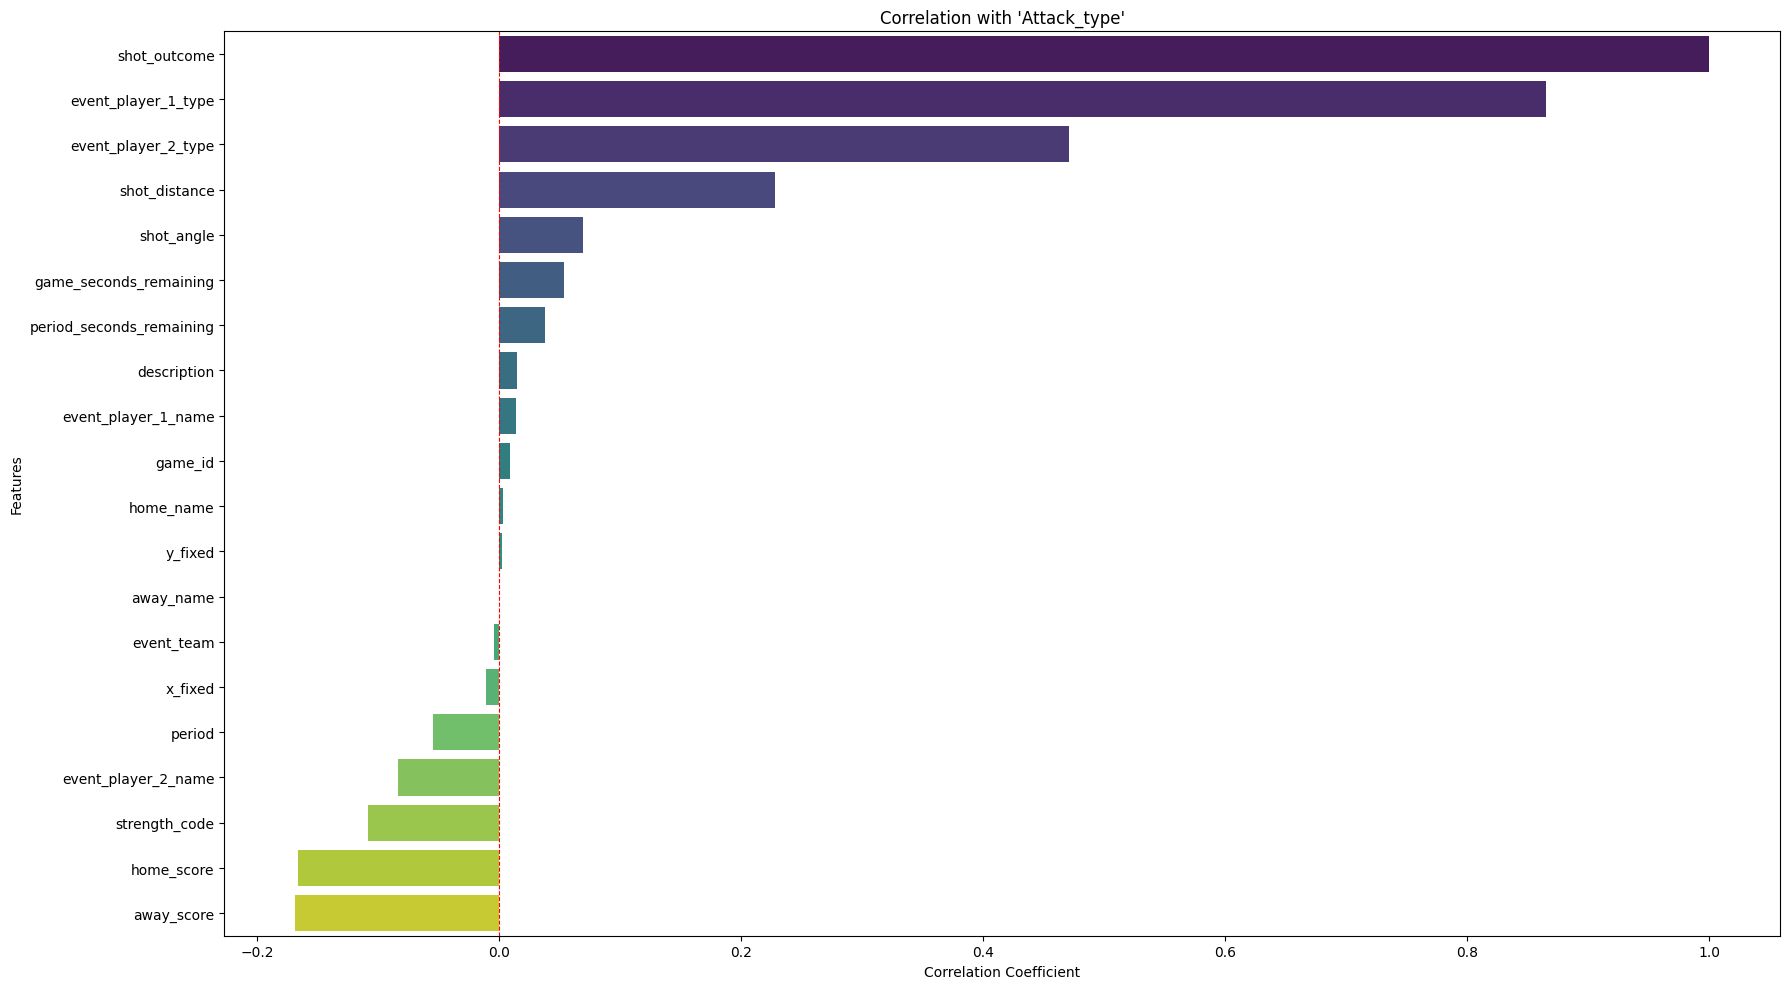

In [63]:
# Correlation with the target variable

corr_matrix = df_preprocessed.corr()
target_corr = corr_matrix['shot_outcome'].sort_values(ascending=False)
print(target_corr)
# Correlation with the target variable

plt.figure(figsize=(18, 10))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette="viridis"
)
plt.title("Correlation with 'Attack_type'")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.axvline(0, color='red', linestyle='--', linewidth=0.8)  # Highlight zero correlation
plt.tight_layout()
plt.show()




positively strong corolation : shot distance  , event_player_2_type,shot_angle,event_player_1_type.


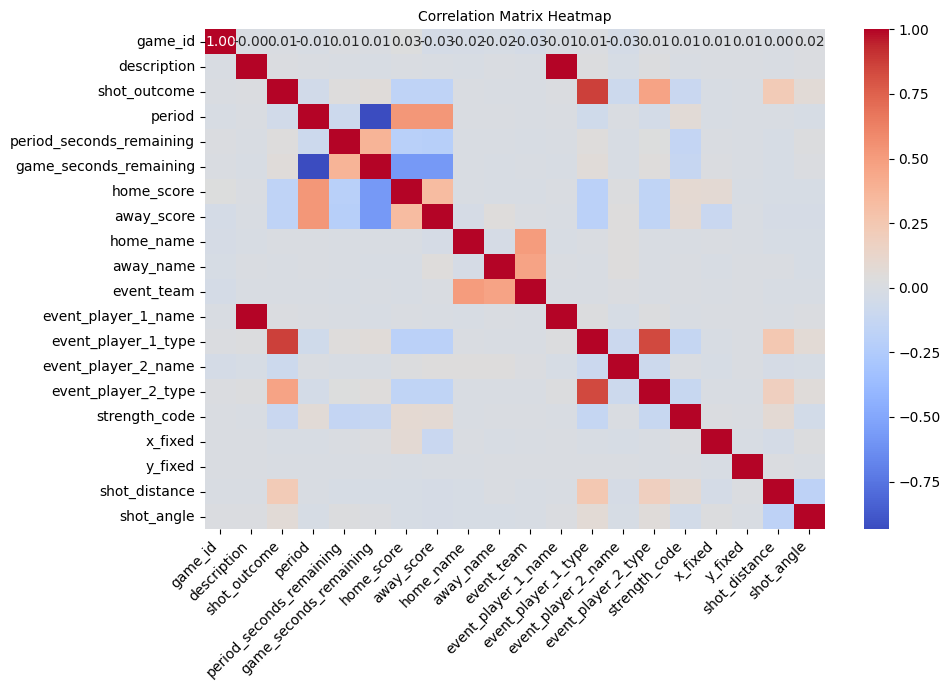

In [64]:

# Plot the heatmap
plt.figure(figsize=(10, 7))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add title for better readability
plt.title("Correlation Matrix Heatmap", fontsize=10)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal
plt.tight_layout()  # Avoid clipping labels
plt.show()




In [65]:
df_preprocessed= df_preprocessed.drop('description',axis=1)

### Feature Importances

Feature importance is a technique used to quantify how influential each input feature is in predicting the target variable in a machine learning model. It helps determine which features contribute most to the model's performance or accuracy.It can be calculated in various ways depending on the model type and context. For tree-based models, it is often measured by the reduction in impurity (e.g., Gini impurity or entropy) achieved when a feature is used to split the data. Permutation importance, on the other hand, assesses importance by shuffling feature values and observing the resulting change in model performance. 
In feature engineering,it helps with feature selection by identifying and retaining only the most influential features, thereby reducing dimensionality and enhancing model efficiency. At the same time, it allows practitioners to eliminate irrelevant or redundant features that might introduce noise.Additionally, it can help detect overfitting if certain features, such as ID columns, appear overly influential, indicating potential data leakage. 
Since my dataset contains 160,000 entries and 22 features, I will use feature importance from a Random Forest model alongside the results of correlation analysis. Afterward, I will evaluate both the correlation analysis and feature importance results to identify the most effective predictors.

                     Feature  Importance
12       event_player_2_type    0.572931
10       event_player_1_type    0.359479
16             shot_distance    0.017915
14                   x_fixed    0.007845
4                 home_score    0.007471
5                 away_score    0.006692
11       event_player_2_name    0.005227
3     game_seconds_remaining    0.003500
15                   y_fixed    0.003269
17                shot_angle    0.002681
2   period_seconds_remaining    0.002386
0                    game_id    0.002047
9        event_player_1_name    0.001834
13             strength_code    0.001704
6                  home_name    0.001501
7                  away_name    0.001372
8                 event_team    0.001245
1                     period    0.000901


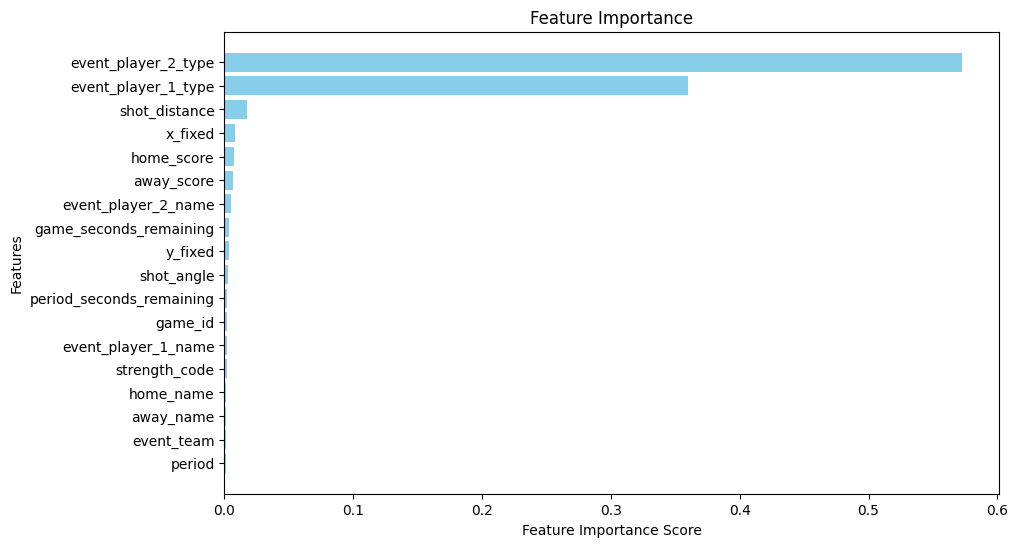

In [66]:
X = df_preprocessed.drop(columns=['shot_outcome'])  # Features
y = df_preprocessed['shot_outcome']                # Target

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()




The features `event_player_2_type` and `event_player_1_type` dominate the model, making them the most important features.

In [67]:
selected = ['event_player_1_type','event_player_2_type','shot_distance' ,'shot_angle','event_player_2_name'  ,'home_score','away_score','period','strength_code' ] # ımportant features + target  


Acording to the results , Features with an absolute correlation score above 6% were selected.

## Visualization 

array([[<Axes: title={'center': 'shot_distance'}>,
        <Axes: title={'center': 'shot_angle'}>],
       [<Axes: title={'center': 'home_score'}>,
        <Axes: title={'center': 'away_score'}>],
       [<Axes: title={'center': 'period'}>, <Axes: >]], dtype=object)

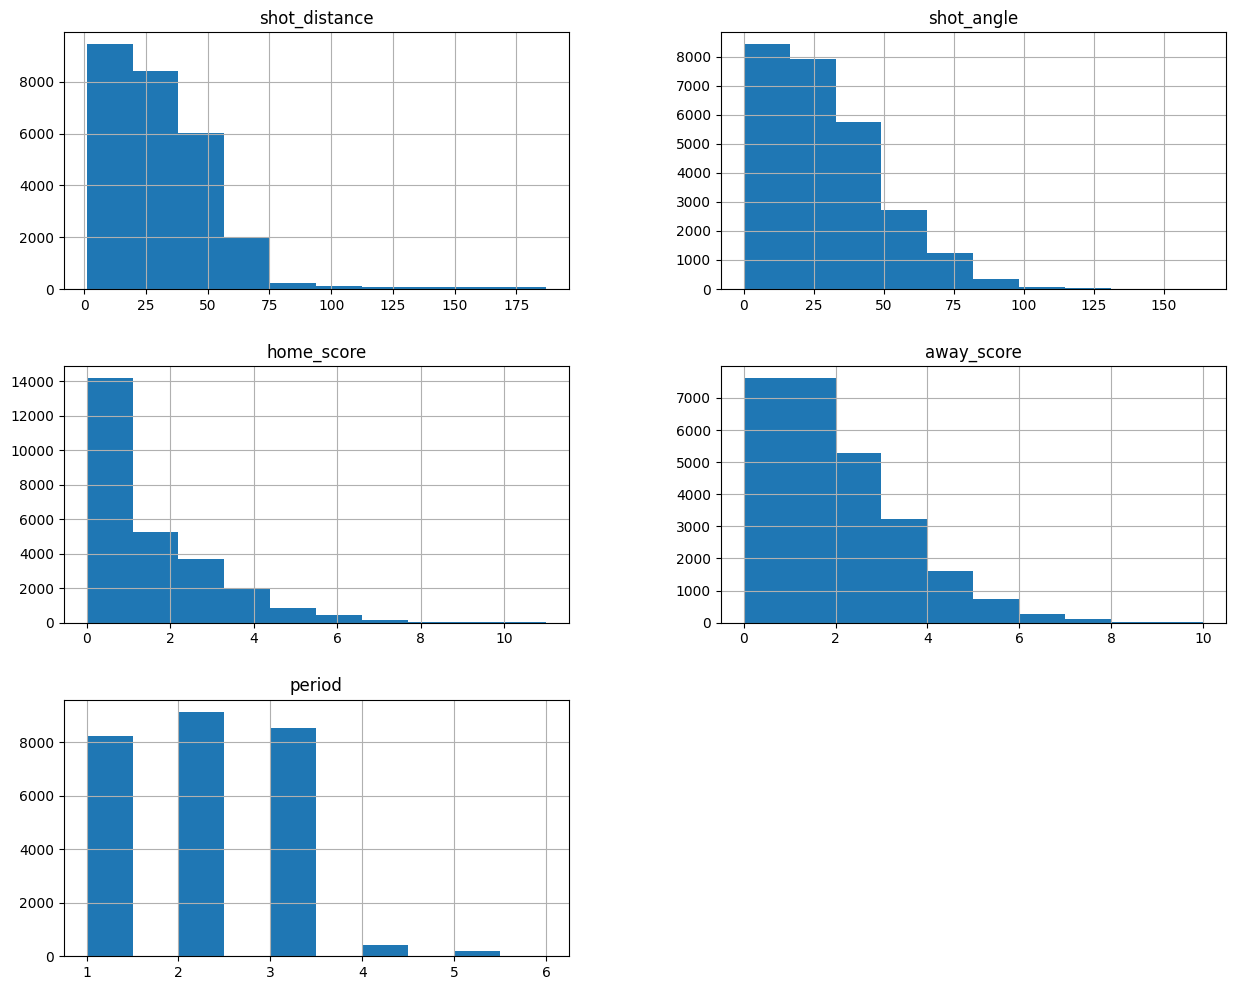

In [68]:
sample_df[selected].hist(figsize=(15,12))

In [69]:
import plotly.express as px

for col in sample_df.drop('description',axis=1).select_dtypes(include=['object','bool']).columns:
    counts = sample_df[col].value_counts().reset_index()
    counts.columns = [col, 'Count']
    
    fig = px.bar(counts, x=col, y='Count', title=f"Distribution of {col}")
    fig.show()


C:\Users\NURŞAH SATILMIŞ\AppData\Local\Temp\ipykernel_25976\522152664.py:4: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.

c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\NURŞAH SATILMIŞ\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` in

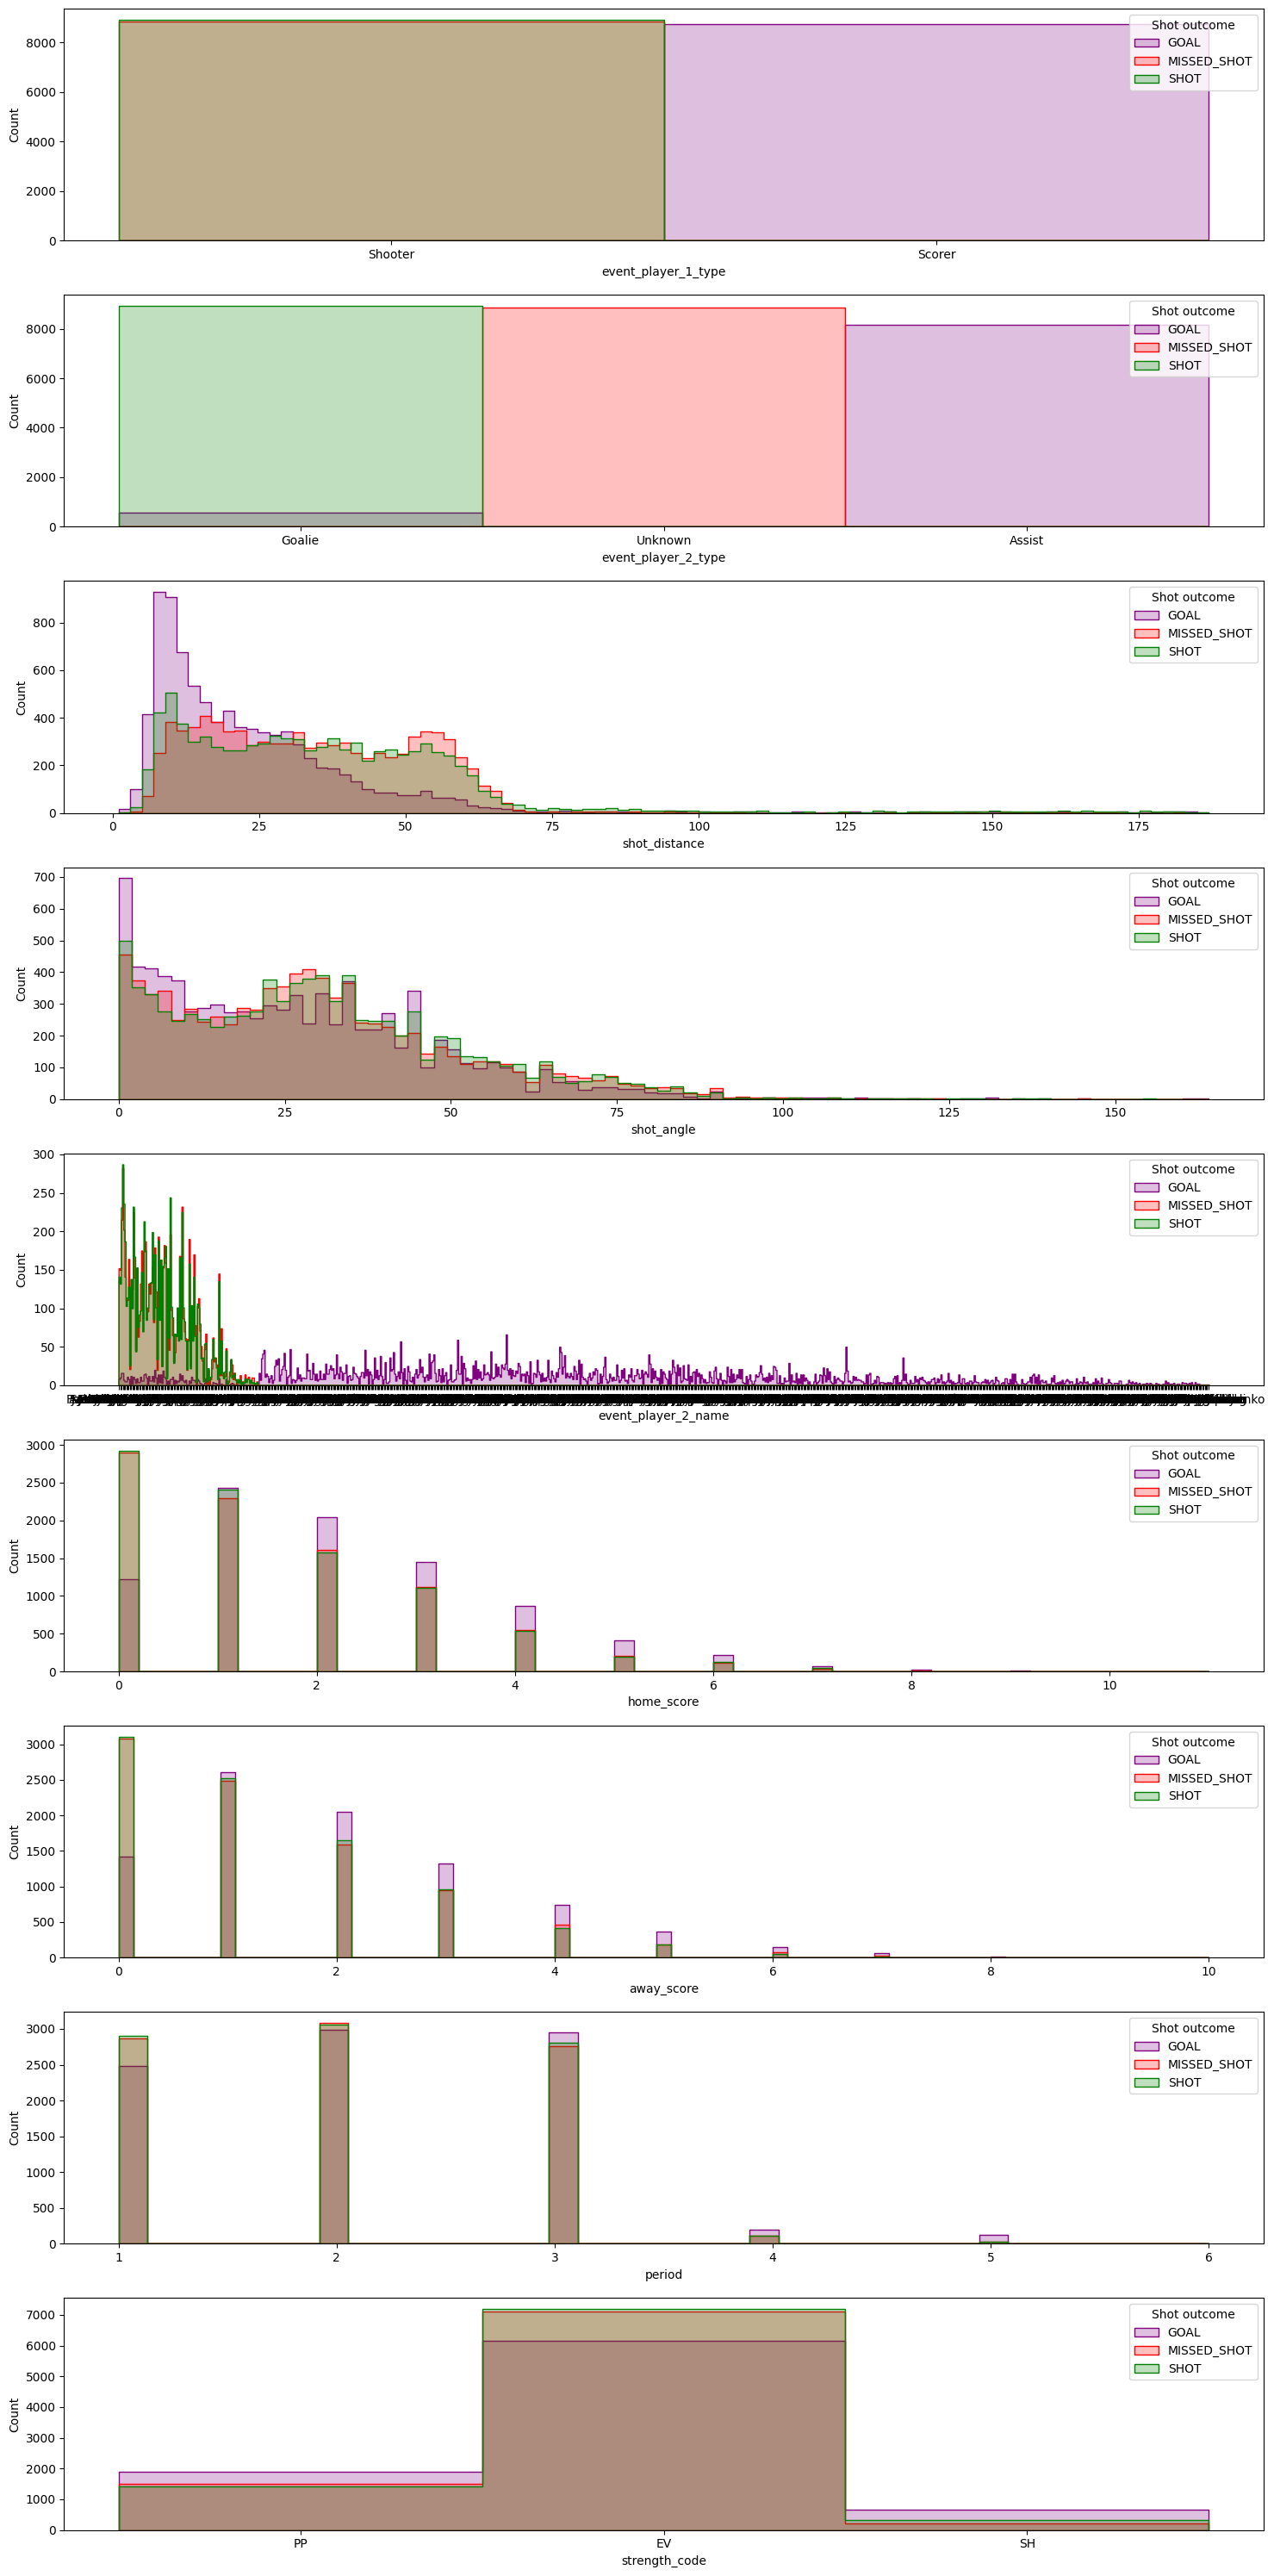

In [70]:

plt.figure(figsize=(15, 30))
for idx, feature in enumerate(selected):
    plt.subplot(9, 1, idx + 1)
    sns.histplot(data=sample_df, x=feature, hue='shot_outcome', element='step', kde=False, palette=['green', 'red','purple','blue'])
    plt.legend(title='Shot outcome', loc='upper right', labels=label_encoding.keys())

plt.tight_layout()
plt.show()


Since event_player_1_type and event_player_2_type provide direct information about the target, they are redundant. It might be a good idea to drop them to avoid multicollinearity and improve model generalization.


In [71]:
selected = ['shot_distance' ,'shot_angle','event_player_2_name'  ,'home_score','away_score','period','strength_code' ] # ımportant features + target  
X = df_preprocessed[selected]
y = df_preprocessed['shot_outcome']                # Target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

X.head()

,shot_distance,shot_angle,event_player_2_name,home_score,away_score,period,strength_code
77888,0.027419,0.057892,372,0.454545,0.1,0.2,1
14485,0.212366,0.123096,303,0.000000,0.1,0.0,1
52194,0.032258,0.000000,349,0.000000,0.0,0.0,0
68083,0.048387,0.224863,53,0.000000,0.0,0.0,0
153039,0.148387,0.222425,225,0.090909,0.1,0.4,0


## Model Building

In [72]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from scipy.stats import mode
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,ConfusionMatrixDisplay


## KNN Classifier

In [73]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [99]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k
        self.class_weights = None  # Initialize class_weights
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)  # Ensure input is a NumPy array
        self.y_train = np.array(y_train)  # Ensure input is a NumPy array
        # Calculate class occurrence for weighting
        unique, counts = np.unique(self.y_train, return_counts=True)
        self.class_weights = {label: 1 / count for label, count in zip(unique, counts)}
    def predict(self, X_test, weights_type=None):
        X_test = np.array(X_test)  # Ensure input is a NumPy array
        y_pred = []
        for x in X_test:
            # Calculate distances to all training samples
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            # Get indices of the k nearest neighbors
            nearest_indices = np.argpartition(distances, self.k)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            # Weighting
            if weights_type == 'distance':
                # Weights inversely proportional to distances
                weights = 1 / np.maximum(distances[nearest_indices], 1e-9)  # Avoid division by zero
                weights /= np.sum(weights)  # Normalize weights
            elif weights_type == 'occurrence':
                # Weights inversely proportional to class occurrence
                weights = np.array([self.class_weights[label] for label in nearest_labels])
            elif weights_type == 'combined':
                # Combined weights (inverse distance * class occurrence)
                distance_weights = 1 / np.maximum(distances[nearest_indices], 1e-9)  # Avoid division by zero
                distance_weights /= np.sum(distance_weights)  # Normalize
                occurrence_weights = np.array([self.class_weights[label] for label in nearest_labels])
                weights = distance_weights * occurrence_weights
                weights /= np.sum(weights)  # Normalize
            else:
                # No weighting (majority voting)
                y_pred.append(mode(nearest_labels, keepdims=False)[0])
                continue
            # Weighted voting
            weighted_votes = {}
            for label, weight in zip(nearest_labels, weights):
                weighted_votes[label] = weighted_votes.get(label, 0) + weight
            y_pred.append(max(weighted_votes, key=weighted_votes.get)           )# Predict the class with the highest weighted vote
        return np.array(y_pred)  # Return predictions as a NumPy array


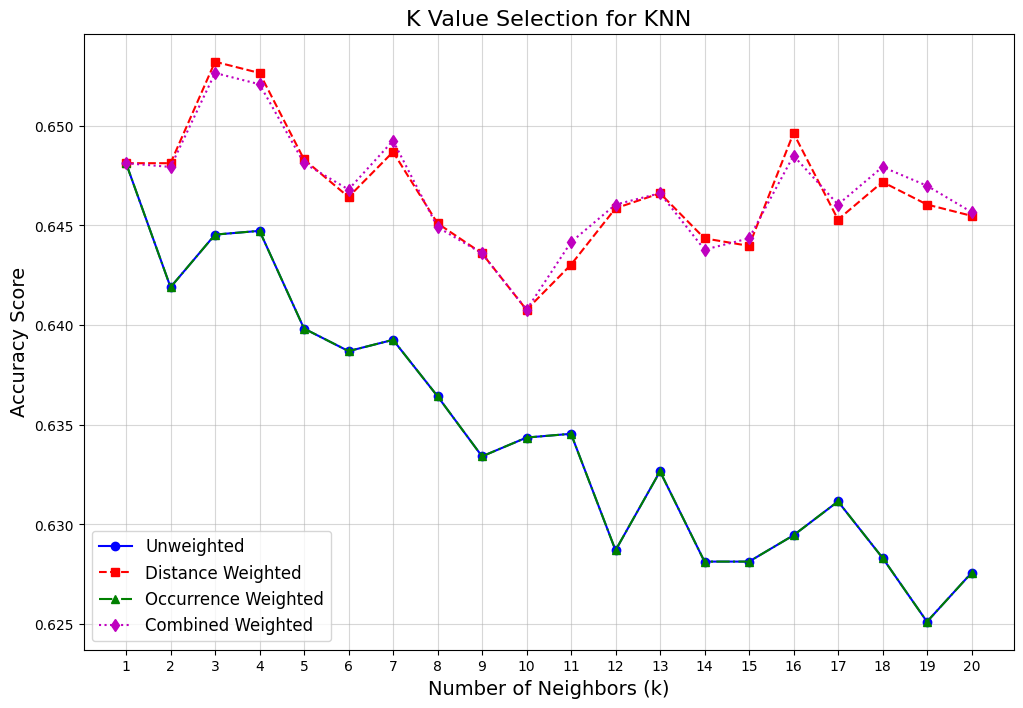

In [103]:
# Optimal k value
k_values = range(1, 21)
accuracy_scores_d = []
accuracy_scores_o = []
accuracy_scores_C = []
accuracy_scores = []

# Evaluate KNN for each k
for k in k_values:
    knn = KNNClassifier(k)
    knn.fit(X_train, y_train)
    
    # Compute accuracy for each weighting method
    accuracy_scores_d.append(accuracy_score(y_test, knn.predict(X_test, 'distance')))
    accuracy_scores_o.append(accuracy_score(y_test, knn.predict(X_test, 'occurrence')))
    accuracy_scores_C.append(accuracy_score(y_test, knn.predict(X_test, 'combined')))
    accuracy_scores.append(accuracy_score(y_test, knn.predict(X_test)))

# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b', label='Unweighted')
plt.plot(k_values, accuracy_scores_d, marker='s', linestyle='--', color='r', label='Distance Weighted')
plt.plot(k_values, accuracy_scores_o, marker='^', linestyle='-.', color='g', label='Occurrence Weighted')
plt.plot(k_values, accuracy_scores_C, marker='d', linestyle=':', color='m', label='Combined Weighted')

# Adding titles and labels
plt.title("K Value Selection for KNN", fontsize=16)
plt.xlabel("Number of Neighbors (k)", fontsize=14)
plt.ylabel("Accuracy Score", fontsize=14)
plt.xticks(k_values)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Display the plot
plt.show()



Accuracy: 0.6400150858004903
              precision    recall  f1-score   support

        GOAL       0.98      0.93      0.96      1748
 MISSED_SHOT       0.48      0.52      0.50      1770
        SHOT       0.49      0.47      0.48      1785

    accuracy                           0.64      5303
   macro avg       0.65      0.64      0.65      5303
weighted avg       0.65      0.64      0.64      5303



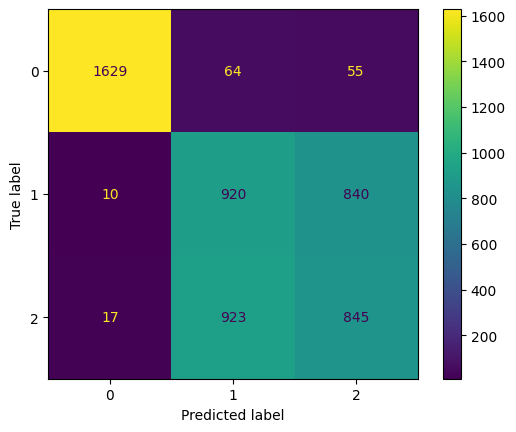

In [178]:

knn_model = KNNClassifier(k=5)
knn_model.fit(X_train,y_train)
y_pred_knn = knn_model.predict(X_test,'distance')
print('Accuracy:', accuracy_score(y_test, y_pred_knn))
print(classification_report(
    y_test, 
    y_pred=y_pred_knn, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1500, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test)

# Evaluation
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy of the best model: {accuracy:.2f}")
print(classification_report(
    y_test, 
    y_pred=y_pred_log, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))

cm_log = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=label_encoding.keys())
disp.plot()

NameError: name 'X_train' is not defined

### Random Forest

In [183]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Accuracy of the best model: 0.53
              precision    recall  f1-score   support

        GOAL       0.63      0.75      0.69      1748
 MISSED_SHOT       0.45      0.44      0.44      1770
        SHOT       0.46      0.39      0.42      1785

    accuracy                           0.53      5303
   macro avg       0.51      0.53      0.52      5303
weighted avg       0.51      0.53      0.52      5303



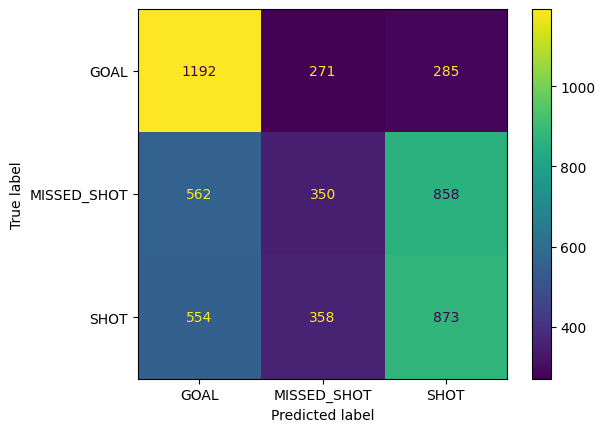

In [185]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the best model: {accuracy:.2f}")
print(classification_report(
    y_test, 
    y_pred=y_pred_rf, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))

cm_log = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=label_encoding.keys())
disp.plot()

In [ ]:
break

In [186]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution (randomized search)
param_dist = {
    'n_estimators': np.arange(100, 500,100),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]                   # Whether to use bootstrap sampling
}

rf_classifier = RandomForestClassifier(random_state=45)

# Initialize RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist,
                                    n_iter=100, cv=10, n_jobs=-1, random_state=45, verbose=2)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_rf_classifier = random_search.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_classifier.predict(X_test)




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Accuracy of the best model: 0.53
              precision    recall  f1-score   support

        GOAL       0.63      0.78      0.70      1748
 MISSED_SHOT       0.47      0.45      0.46      1770
        SHOT       0.46      0.37      0.41      1785

    accuracy                           0.53      5303
   macro avg       0.52      0.53      0.52      5303
weighted avg       0.52      0.53      0.52      5303



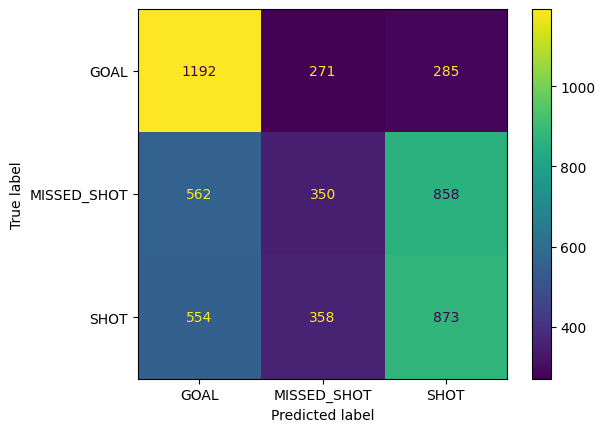

In [188]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Best Parameters: {best_params}")
print(f"Accuracy of the best model: {accuracy:.2f}")
print(classification_report(
    y_test, 
    y_pred=y_pred_rf, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))
cm_RF = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=label_encoding.keys())
disp.plot()



## XGBOOST 

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)




# Ensure y_test and y_pred contain numerical values corresponding to the label encoding
print(classification_report(
    y_test, 
    y_pred=y_pred, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))

              precision    recall  f1-score   support

        GOAL       0.81      0.81      0.81      1732
 MISSED_SHOT       0.49      0.53      0.51      1778
        SHOT       0.50      0.46      0.48      1793

    accuracy                           0.60      5303
   macro avg       0.60      0.60      0.60      5303
weighted avg       0.60      0.60      0.60      5303



In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer



# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'reg_alpha': 0.5,
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Uniform sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Uniform sampling
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),  # Uniform sampling
        'objective': 'multi:softmax',
        'num_class': 3,
        'device': 'cuda'
    }

    # Define Stratified K-Fold for balanced class representation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Initialize the XGBClassifier
    model = XGBClassifier(**params)

    # Cross-validation with F1-weighted as the scoring metric
    f1_scorer = make_scorer(f1_score, average='weighted')
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=f1_scorer, n_jobs=-1)

    # Return the average F1-weighted score
    return scores.mean()

# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Maximize F1-Score
study.optimize(objective, n_trials=10, timeout=3600)  # Limit trials or 1 hour

# Display the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)


In [ ]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate on validation or test data
y_pred = final_model.predict(X_test)




# Ensure y_test and y_pred contain numerical values corresponding to the label encoding
print(classification_report(
    y_test, 
    y_pred=y_pred, 
    labels=list(label_encoding.values()), 
    target_names=list(label_encoding.keys())
))


In [ ]:
xgb_model = XGBClassifier(**xgb_cv_model.best_params_,objective='multi:softmax', num_class=4)
xgb_model.fit(X_train,y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report,accuracy_score
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print("XGBoost results:\n",classification_report(y_test, y_pred_xgb))
